#Zadanie 2 (7 pkt)
Celem zadania jest rozwiązanie zadania optymalizacji przy pomocy algorytmu genetycznego. Należy znaleźć minimum zadanej funkcji:
\begin{equation}
f(x) = 1.5-\exp \left\{-x_1^2-x_2^2\right\}-0.5 \exp \left\{-\left(x_1-1\right)^2-\left(x_2+2\right)^2\right\}
\end{equation}
Należy wykorzystać mechanizmy krzyżowania punktowego, mutacji oraz selekcji turniejowej. Proszę wykorzystać przygotowany szkielet i zaimplementować niezbędne metody. Opracowane oprogramowanie powinno być uniwersalne - wymiar funkcji, której minimum szukamy może być dowolny (mechanizm *args). Punktacja wygląda następująco:

*   Stworzenie obiektu klasy *Chromosome* z polem *array*, które jest wektorem aktywnych i nieaktywnych genów - **0.5 pkt**
*   Implementacja metody *decode*, która dekoduje część chromosomu (określoną przez początek (*lower_bound*) i koniec (*upper_bound*)) do postaci liczby rzeczywistej. *aoi* to zakres wartości zdekodowanej liczby rzeczywistej. Przykład: liczba 135 w postaci binarnej zapisana przy użyciu 8 bitów to 1000 0111, jeśli nasze *aoi* to [0, 1], to 135 sprowadzone do tego zakresu to 0.529. Można skorzystać z funkcji pomocniczej *min_max_norm* - **1 pkt**
*   Implementacja metody *mutation*, która przyjmuje jako argument prawdopodobieństo mutacji i zmienia wartość jedego, losowego genu na przeciwną - **0.5 pkt**
*   Implementacja metody *crossover*, która wykonuje operację krzyżowania jednopunktowego - **1 pkt**
*   Implementacja metody *eval_objective_func*, która dekoduje cały chromosom (otrzymuje się argumenty funkcji) oraz zwraca wartość funkcji celu dla tych argumentów - **1 pkt**
*   Implementacja metody *tournament_selection*, która przeprowadza selekcję turniejową - **1 pkt**
*   Implementacja metody *reproduce*, która generuje nowe pokolenie - z pewnym prawdopodobieństwem przeprowadza krzyżowanie jednopunktowe lub "przerzuca" rodziców do nowego pokolenia - **0.5 pkt**
*   Implementacja metody *run*, która wykonuje cały alorytm genetyczny dla określonej liczby pokoleń. W każdym pokoleniu należy zapisać dane osobnika z najlepszym chromosomem zdekodowane wartości x i y oraz wartość funkcji strat dla tego osobnika - **0.5 pkt**
*   Proszę, podobnie jak miało to miejsce w przypadku metody gradientowej z poprzednich zajęć, wygenerować wykres przy użyciu funkcji *plot_func* (w przypadku innego typu argumentu *trace*, funkcję można zmodyfikować. Wykres powinien przedstawiać funkcję, której minimum poszukujemy oraz punkty odpowiadające najlepszym osobnikom w danych generacjach, których kolor jest coraz jaśniejszy wraz ze zbliżaniem się do minimum. Proszę zapisać swoje wnioski, w szczególności w odniesieniu do metody gradientowej. - **1 pkt**


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
def min_max_norm(val, min_val, max_val, new_min, new_max):
  return (val - min_val) * (new_max - new_min) / (max_val - min_val) + new_min

In [3]:
class Chromosome:
  def __init__(self, length, array=None):
    self.array = array if array is not None else [random.randint(0, 1) for _ in range(length)]

  def decode(self, lower_bound, upper_bound, aoi):
    new_array = self.array[ lower_bound : upper_bound + 1 ]
    value = int( "".join( map( str, new_array ) ), 2 )
    max_value = 2 ** ( len( new_array ) ) - 1
    return(min_max_norm( value, 0, max_value, aoi[0], aoi[1] ))

  def mutation(self, probability):
    if random.random() <= probability:
      mutated_index = random.randint ( 0, len(self.array) - 1)
      self.array[ mutated_index ] ^= 1

  def crossover(self, other):
    cross_point = random.randint( 1, len(self.array)-1 )
    child1 = Chromosome( length = len(self.array), array = self.array[:cross_point] + other.array[cross_point:])
    child2 = Chromosome( length = len(self.array), array = other.array[:cross_point] + self.array[cross_point:])
    return child1, child2

Chromosome length: 20
Population size: 500
Tournament size: 2


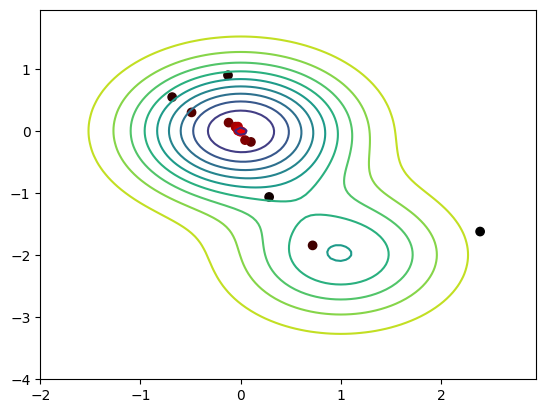

Best solution: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0]
Decoded best solution (x,y):  (0.0029325513196480912, -0.008797653958944274)
Value of the best solution 0.4965761290213157


In [4]:
class GeneticAlgorithm:
  def __init__(self, chromosome_length, obj_func_num_args, objective_function, aoi, population_size=1000,
               tournament_size=2, mutation_probability=0.05, crossover_probability=0.8, num_steps=30):
    assert chromosome_length % obj_func_num_args == 0, "Number of bits for each argument should be equal"
    self.chromosome_lengths = chromosome_length
    self.obj_func_num_args = obj_func_num_args
    self.bits_per_arg = int(chromosome_length / obj_func_num_args)
    self.objective_function = objective_function
    self.aoi = aoi
    self.tournament_size = tournament_size
    self.mutation_probability = mutation_probability
    self.crossover_probability = crossover_probability
    self.num_steps = num_steps
    self.population = []
    self.population_size = population_size
    self.initialize_population()

  def initialize_population(self):
    self.population = []
    for i in range(self.population_size):
      self.population.append(Chromosome(self.chromosome_lengths))

  def eval_objective_func(self, chromosome):
    decoded_args = []
    for i in range(self.obj_func_num_args):
      start = i * self.bits_per_arg
      end = start + self.bits_per_arg - 1
      decoded_args.append(chromosome.decode(start, end, self.aoi))
    func_value = self.objective_function(*decoded_args)
    return {tuple(decoded_args): func_value}


  def tournament_selection(self):
    tournament = random.sample(self.population, self.tournament_size)
    tournament_values = [(chromosome, self.eval_objective_func(chromosome)) for chromosome in tournament]
    best_chromosome = min(tournament_values, key=lambda x: list(x[1].values())[0])[0]
    return best_chromosome

  def reproduce(self, parents):
    parent_1, parent_2 = parents
    if random.random() <= self.crossover_probability:
      child_1, child_2 = parent_1.crossover(parent_2)
    else:
      child_1, child_2 = parent_1, parent_2
    child_1.mutation(self.mutation_probability)
    child_2.mutation(self.mutation_probability)
    return child_1, child_2

  def plot_func(self, trace):
    X = np.arange(-2, 3, 0.05)
    Y = np.arange(-4, 2, 0.05)
    X, Y = np.meshgrid(X, Y)
    Z = 1.5 - np.exp(-X ** (2) - Y ** (2)) - 0.5 * np.exp(-(X - 1) ** (2) - (Y + 2) ** (2))
    plt.figure()
    plt.contour(X, Y, Z, 10)
    cmaps = [[ii / len(trace), 0, 0] for ii in range(len(trace))]
    plt.scatter([x[0] for x in trace], [x[1] for x in trace], c=cmaps)
    plt.show()

  def run(self):
    best_solution = None
    best_solution_value = float('inf')
    best_args = []
    trace = []
    for step in range(self.num_steps):
      new_population = []
      for j in range(self.population_size // 2):
        parents = [self.tournament_selection() for x in range(2)]
        child_1, child_2 = self.reproduce(parents)
        new_population.extend([child_1, child_2])
      self.population = new_population
      for chromosome in self.population:
       result = self.eval_objective_func(chromosome)
       value = list(result.values())[0]
       decoded_args = list(result.keys())[0]
       if value < best_solution_value:
         best_solution = chromosome
         best_solution_value = value
         best_args = decoded_args
         trace.append(decoded_args)
      #print(f"Step {step + 1}, Min Value: {best_solution_value}")
    self.plot_func(trace)
    return best_solution, best_solution_value, trace, best_args

def sample_objective_function(x1, x2):
    result = 1.5 - np.exp(-x1**2 - x2**2) - 0.5 * np.exp(-(x1 - 1)**2 - (x2 + 2)**2)
    return result

print("Chromosome length: 20")
print("Population size: 500")
print("Tournament size: 2")


ga = GeneticAlgorithm(chromosome_length=20,
                      obj_func_num_args=2,
                      objective_function=sample_objective_function,
                      aoi=[-3, 3],
                      population_size=500,
                      tournament_size=2)

best_solution, best_value, trace, best_args = ga.run()
print("Best solution:", best_solution.array)
print("Decoded best solution (x,y): ", best_args)
print("Value of the best solution", best_value)




